## 1 - Todo processo feito na análise e clusterização será feito novamente para realizarmos as previsões



In [ ]:
## Carregando as bibliotecas necessárias

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans  ### NÃO SUPERVISIONADA
from sklearn.decomposition import PCA   ### NÃO SUPERVISIONADA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score  ### AVALIAR ALGORITIMOS DE CLUSTERIZAÇÃO
import warnings
import joblib
warnings.filterwarnings("ignore")
!pip install Prophet
from prophet import Prophet  ### PREVISÃO DE VENDAS



In [ ]:
## CARREGANDO O DATASET EM VARIÁVEIS DIFERENTES, DEVIDO AO PROBLEMA DO LABEL ENCODER

# PRIMEIRO A VARIÁVEL QUE TERÁ TODO TRATAMENTO PARA TREINAR O ALGORITIMO K-MEANS

dados_frame = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')

# SEGUNDA VARIÁVEL QUE TERÁ PARTE DO TRATAMENTO, PARA PODERMOS COLOCAR OS CLUSTERS POSTERIORMENTE NA BASE DE DADOS ORIGINAL

dados_frame_completo = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')

# BASE DE DADOS UTILIZAR PARA TERMOS OS CLUSTERS

dados_frame_completo_carregar_labels = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')




In [ ]:
### CRIANDO LABEL PARA OS CATEGÓRICOS

from sklearn.preprocessing import LabelEncoder
import pandas as pd


label_encoder = LabelEncoder()

dados_frame['year_month'] = pd.to_datetime(dados_frame['year_month'])
dados_frame['region'] = label_encoder.fit_transform(dados_frame['region'])
dados_frame['SOMA'] = dados_frame['sales'] * dados_frame['mean_price']
dados_frame = dados_frame[dados_frame['year_month'] != '2011-01']

dados_frame_completo = dados_frame_completo[dados_frame_completo['year_month'] != '2011-01']
dados_frame_completo['year_month'] = pd.to_datetime(dados_frame_completo['year_month'])
dados_frame_completo['SOMA'] = dados_frame_completo['sales'] * dados_frame_completo['mean_price']
dados_frame_completo['region'] = label_encoder.fit_transform(dados_frame_completo['region'])


dados_frame_completo_carregar_labels = dados_frame_completo_carregar_labels[dados_frame_completo_carregar_labels['year_month'] != '2011-01']
dados_frame_completo_carregar_labels['year_month'] = pd.to_datetime(dados_frame_completo_carregar_labels['year_month'])
dados_frame_completo_carregar_labels['SOMA'] = dados_frame_completo_carregar_labels['sales'] * dados_frame_completo_carregar_labels['mean_price']

In [ ]:
### RETIRANDO DADOS SEM VENDAS E AQUELES COM MEAN_PRICE SEM DADOS

dados_frame = dados_frame[dados_frame['sales'] != 0]
dados_frame = dados_frame[~(dados_frame['mean_price'].isna() & (dados_frame['sales'] > 0))]
dados_frame_completo = dados_frame_completo[dados_frame_completo['sales'] != 0]
dados_frame_completo = dados_frame_completo[~(dados_frame_completo['mean_price'].isna() & (dados_frame_completo['sales'] > 0))]
dados_frame_completo_carregar_labels = dados_frame_completo_carregar_labels[dados_frame_completo_carregar_labels['sales'] != 0]
dados_frame_completo_carregar_labels = dados_frame_completo_carregar_labels[~(dados_frame_completo_carregar_labels['mean_price'].isna() & (dados_frame_completo_carregar_labels['sales'] > 0))]

In [ ]:
### RETIRANDO OUTLIERS DO PRIMEIRO E QUARTO QUARTIS

Q1 = dados_frame['SOMA'].quantile(0.25)
Q3 = dados_frame['SOMA'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.0 * IQR
limite_superior = Q3 + 1.0 * IQR

dados_frame = dados_frame[(dados_frame['SOMA'] >= limite_inferior) & (dados_frame['SOMA'] <= limite_superior)]

In [ ]:
# EXTRAINDO OS DADOS SEM VENDAS = 0  E MEAN_PRICE SEM DADOS PARA GERAR UM ARQUIVO MENOR QUE 200 MEGAS (LIMITE PARA SUBIR ARQUIVO NO STREAMLIT)
dados_frame_completo_carregar_labels.to_csv('dados_frame_completo.csv', index=False)


In [ ]:
### PADRONIZANDO OS DADOS PARA UTILIZARMOS A MESMA ESCALA NO ALGORITIMO E TERMOS MELHORES RESULTADOS

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

dados_frame_sem_outliers_selecionados = scaler.fit_transform(dados_frame[['sales', 'mean_price', 'region']])

dados_frame_completo = scaler.fit_transform(dados_frame_completo[['sales', 'mean_price', 'region']])

In [ ]:
dados_frame_completo_carregar_labels

,year_month,id,item,category,department,store,store_code,region,sales,mean_price,SOMA
30520,2011-02-01,ACCESORIES_1_004_BOS_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,43,5.7722,248.2046
30521,2011-02-01,ACCESORIES_1_004_BOS_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,70,5.7722,404.0540
30524,2011-02-01,ACCESORIES_1_004_NYC_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,127,5.7722,733.0694
30525,2011-02-01,ACCESORIES_1_004_NYC_3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Tribeca,NYC_3,New York,12,5.7722,69.2664
30526,2011-02-01,ACCESORIES_1_004_NYC_4,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Brooklyn,NYC_4,New York,27,5.7722,155.8494
...,...,...,...,...,...,...,...,...,...,...,...
1951355,2016-04-01,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,133,1.2000,159.6000
1951356,2016-04-01,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,38,1.2000,45.6000
1951357,2016-04-01,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,75,1.2000,90.0000
1951358,2016-04-01,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,66,1.2000,79.2000


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# UTILIZANDO O PRINCIPAL COMPONENTS ANALYSIS PARA DIMINUIR AS COLUNAS E TERMOS MELHOR VISÃO DA DIVISÃO REALIZADA PELO ALGORITIMO

pca = PCA(n_components=2)
pca2 = PCA(n_components=2)

# Utilizando o PCA em dados já normalizados e sem outliers
componentes_principais = pca.fit_transform(dados_frame_sem_outliers_selecionados)
componentes_principais = pd.DataFrame(componentes_principais, columns=['Componente 1', 'Componente 2'])

# Utilizando o PCA em dados somente com a exclusão dos sales = 0 e mean_price sem dados

componentes_principais2 = pca2.fit_transform(dados_frame_completo)
componentes_principais2 = pd.DataFrame(componentes_principais2, columns=['Componente 1', 'Componente 2'])

# Criar DataFrame

df = pd.DataFrame(componentes_principais)

df2 = pd.DataFrame(componentes_principais2)

# Treinar o modelo KMeans (não será visualizado o resultado pois já foi feito em análise anterior)
kmeans_TREINADO = KMeans(n_clusters=5, random_state=100, n_init=20, max_iter=600)
kmeans_TREINADO.fit(df)
dados_frame_completo_carregar_labels['Grupo'] = kmeans_TREINADO.predict(df2)




In [ ]:
# REORGANIZANDO O INDEX

dados_frame_completo_carregar_labels.reset_index(drop=True, inplace=True)

In [ ]:
# GERADO O DATAFRAME COM OS CLUSTERS, VAMOS ANALISÁ-LO

dados_frame_completo_carregar_labels

,year_month,id,item,category,department,store,store_code,region,sales,mean_price,SOMA,Grupo
0,2011-02-01,ACCESORIES_1_004_BOS_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,43,5.7722,248.2046,2
1,2011-02-01,ACCESORIES_1_004_BOS_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,70,5.7722,404.0540,2
2,2011-02-01,ACCESORIES_1_004_NYC_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,127,5.7722,733.0694,1
3,2011-02-01,ACCESORIES_1_004_NYC_3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Tribeca,NYC_3,New York,12,5.7722,69.2664,1
4,2011-02-01,ACCESORIES_1_004_NYC_4,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Brooklyn,NYC_4,New York,27,5.7722,155.8494,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1352597,2016-04-01,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,133,1.2000,159.6000,4
1352598,2016-04-01,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,38,1.2000,45.6000,1
1352599,2016-04-01,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,75,1.2000,90.0000,0
1352600,2016-04-01,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,66,1.2000,79.2000,0


# INICIANDO AS PREVISÕES COM O PROPHET.


In [ ]:

# PRIMEIRO IREMOS TRANSFORMAR AS COLUNAS YEAR_MONTH PARA DS E A SOMA EM Y (TARGET)

# TRANSFORMANDO A COLUNA DS EM ANO/MÊS PARA ADAPTAR AO PROPHET

!pip install Prophet
from prophet import Prophet
dados_frame_teste = dados_frame_completo_carregar_labels.rename(columns={'year_month': 'ds', 'SOMA': 'y'})
dados_frame_teste['ds'] = pd.to_datetime(dados_frame_teste['ds'], errors='coerce')
dados_frame_teste['ds'] = dados_frame_teste['ds'].dt.strftime('%Y-%m')

In [ ]:
# AGRUPANDO OS DADOS PARA O PROPHET
dados_frame_agrupamento = dados_frame_teste.groupby(['ds'])[['y']].sum().sort_values('ds').reset_index()

In [ ]:
# UTILIZANDO O FIT PARA O ALGORITIMO

# ESCOLHI INTERVALO DE CONFIANÇA DE 95% E SAZONALIDADE É MENSAL

m = Prophet(interval_width=0.95, daily_seasonality=False)
model = m.fit(dados_frame_agrupamento)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpac518tiu/6waetpxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpac518tiu/lx6mwxfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72402', 'data', 'file=/tmp/tmpac518tiu/6waetpxh.json', 'init=/tmp/tmpac518tiu/lx6mwxfx.json', 'output', 'file=/tmp/tmpac518tiu/prophet_model7rzxzw92/prophet_model-20241026184513.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:45:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=20, freq = 'MS')
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-02-01,2.380792e+06,2.092077e+06,2.441169e+06,2.380792e+06,2.380792e+06,-117341.530973,-117341.530973,-117341.530973,-117341.530973,-117341.530973,-117341.530973,0.0,0.0,0.0,2.263450e+06
1,2011-03-01,2.435088e+06,2.308853e+06,2.664172e+06,2.435088e+06,2.435088e+06,59821.891389,59821.891389,59821.891389,59821.891389,59821.891389,59821.891389,0.0,0.0,0.0,2.494910e+06
2,2011-04-01,2.495202e+06,2.300109e+06,2.658201e+06,2.495202e+06,2.495202e+06,-9076.269611,-9076.269611,-9076.269611,-9076.269611,-9076.269611,-9076.269611,0.0,0.0,0.0,2.486125e+06
3,2011-05-01,2.553376e+06,2.404132e+06,2.757284e+06,2.553376e+06,2.553376e+06,23202.240409,23202.240409,23202.240409,23202.240409,23202.240409,23202.240409,0.0,0.0,0.0,2.576579e+06
4,2011-06-01,2.613490e+06,2.359948e+06,2.724847e+06,2.613490e+06,2.613490e+06,-63794.083013,-63794.083013,-63794.083013,-63794.083013,-63794.083013,-63794.083013,0.0,0.0,0.0,2.549696e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2017-08-01,5.300667e+06,5.253390e+06,5.689272e+06,5.168501e+06,5.450131e+06,169024.254684,169024.254684,169024.254684,169024.254684,169024.254684,169024.254684,0.0,0.0,0.0,5.469692e+06
79,2017-09-01,5.338370e+06,5.137802e+06,5.586661e+06,5.191217e+06,5.500654e+06,25447.568753,25447.568753,25447.568753,25447.568753,25447.568753,25447.568753,0.0,0.0,0.0,5.363817e+06
80,2017-10-01,5.374856e+06,5.143733e+06,5.644173e+06,5.216826e+06,5.555460e+06,15724.801677,15724.801677,15724.801677,15724.801677,15724.801677,15724.801677,0.0,0.0,0.0,5.390581e+06
81,2017-11-01,5.412559e+06,4.977391e+06,5.483326e+06,5.241053e+06,5.608272e+06,-190057.242593,-190057.242593,-190057.242593,-190057.242593,-190057.242593,-190057.242593,0.0,0.0,0.0,5.222501e+06


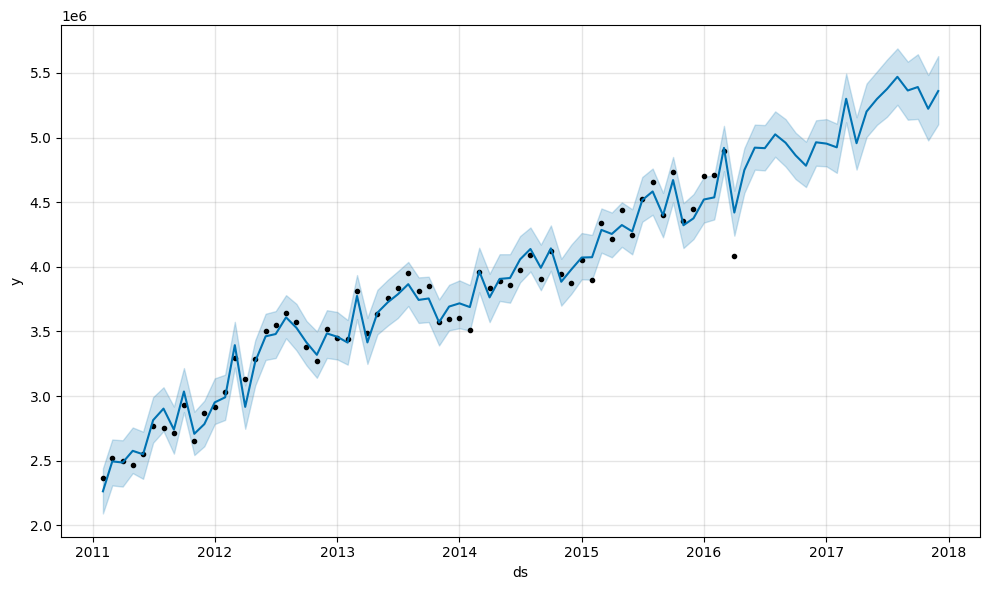

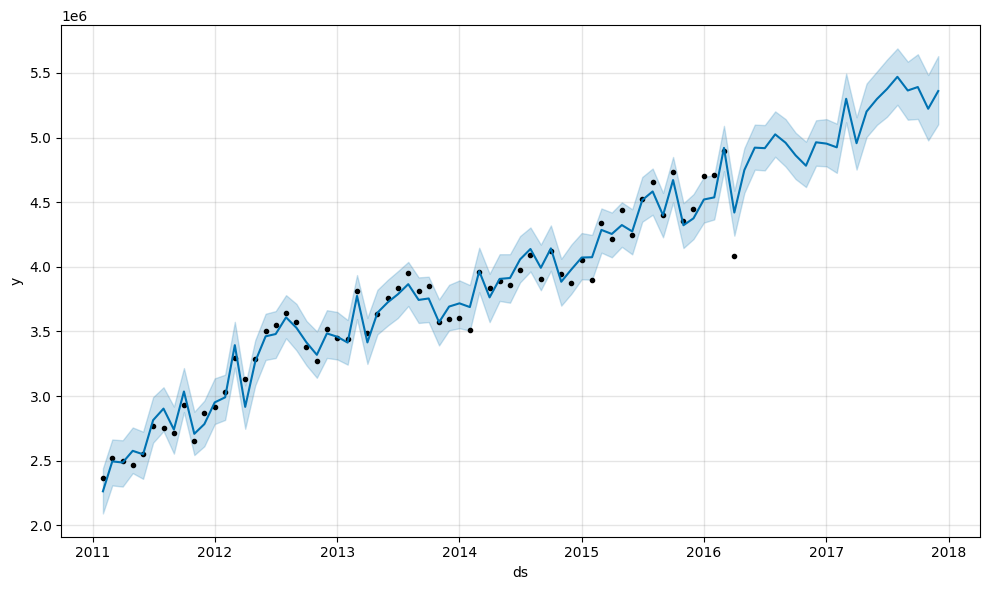

In [ ]:
# ALGUMAS ANÁLISES PRÉVIAS:

# TENDÊNCIA DE ALTA CONSIDERANDO TODA BASE DE DADOS

# DADOS GERADOS POR 20 MESES DESDE 2016-04
model.plot(forecast)


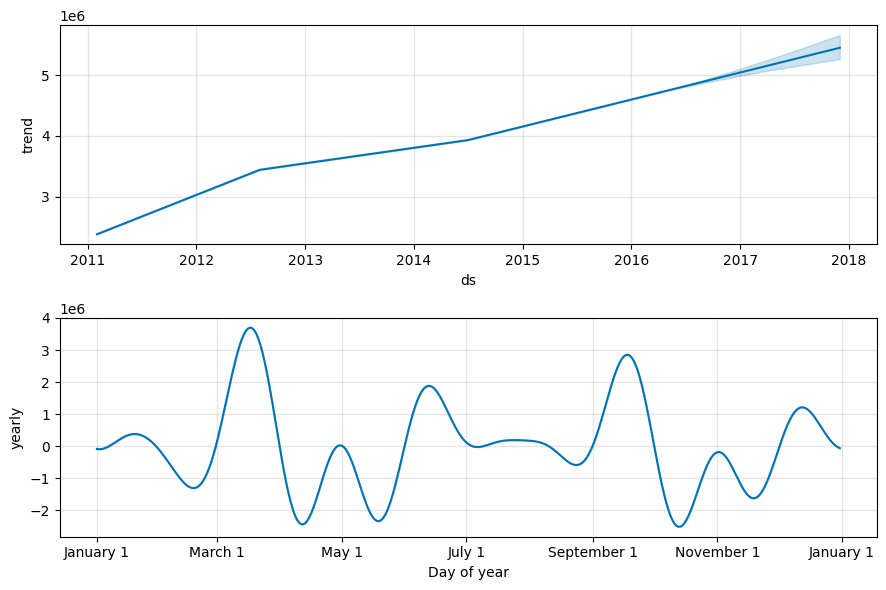

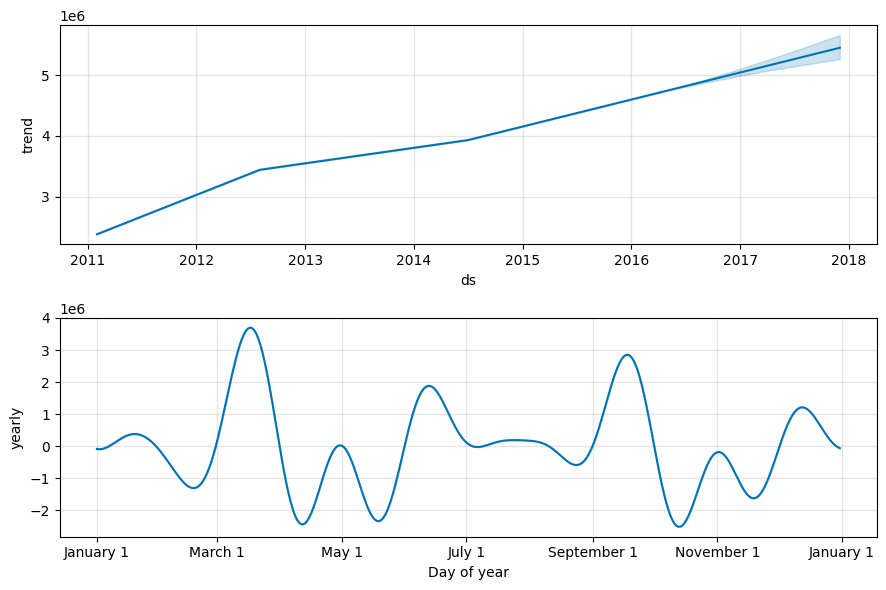

In [ ]:
# TEMOS A TENDÊNCIA POSITIVA

# SAZONALIDADE MAIOR EM MARÇO E FIM DE SETEMBRO. CONSIDERANDO DE 2011 A 2016
model.plot_components(forecast)


In [ ]:
# IREI AGRUPAR OS RESULTADOS PARA ANALISAR OS CLUSTERS

forecast['ds'] = forecast['ds'].dt.strftime('%Y-%m')
merge = pd.merge(dados_frame_agrupamento, forecast[['ds', 'yhat']], on='ds', how='left')

In [ ]:
# TRANSFORMANDO OS DDOS PARA FINCANCEIRO PARA MELHOR OBSERVAÇÃO

merge['y'] = merge['y'].apply(lambda x: "${:,.2f}".format(x))
merge['yhat'] = merge['yhat'].apply(lambda x: "${:,.2f}".format(x))

In [ ]:
# PODEMOS OBSERVAR QUE O Y = VALOR REAL E YHAT = VALOR PREDITO ESTÃO MUITO PRÓXIMOS.

merge

,ds,y,yhat
0,2011-02,"$2,366,535.28","$2,263,450.25"
1,2011-03,"$2,524,813.37","$2,494,909.92"
2,2011-04,"$2,496,325.26","$2,486,125.47"
3,2011-05,"$2,468,169.49","$2,576,578.54"
4,2011-06,"$2,548,820.16","$2,549,695.93"
...,...,...,...
58,2015-12,"$4,449,921.06","$4,375,022.80"
59,2016-01,"$4,703,841.84","$4,520,597.47"
60,2016-02,"$4,710,719.72","$4,537,153.70"
61,2016-03,"$4,899,111.41","$4,920,088.13"


In [ ]:
# MAS USAREMOS O CROSS_VALIDATION PARA VERIFICAR COM MAIS PRECISÃO

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Supondo que 'df' seja seu DataFrame com dados mensais
model = Prophet()
model.fit(dados_frame_agrupamento)

# Realizar a validação cruzada
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Calcular as métricas de desempenho
df_p = performance_metrics(df_cv)
print(df_p.head())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpac518tiu/59a6v7cp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpac518tiu/46w7q2_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8592', 'data', 'file=/tmp/tmpac518tiu/59a6v7cp.json', 'init=/tmp/tmpac518tiu/46w7q2_t.json', 'output', 'file=/tmp/tmpac518tiu/prophet_modelxflyauup/prophet_model-20241026184517.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:45:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2013-04-12 00:00:00 and 2015-04-02 00:00:00

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpac518tiu/smv79g9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpac518tiu/vzaay3kq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43056', 'data', 'file=/tmp/tmpac518tiu/smv79g9h.json', 'init=/tmp/tmpac518tiu/vzaay3kq.json', 'output', 'file=/tmp/tmpac518tiu/prophet_modelnimecu15/prophet_model-20241026184519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:45:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpac518tiu/wb2excsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpac518tiu/5gsjkb9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

  horizon           mse           rmse            mae      mape     mdape  \
0 50 days  2.451619e+10  156576.456044  128413.108449  0.031861  0.023553   
1 53 days  3.682213e+10  191890.920921  166236.775519  0.042390  0.041131   
2 55 days  3.601490e+10  189775.929937  155400.756456  0.039341  0.041131   
3 58 days  3.416124e+10  184827.594250  140757.774129  0.035576  0.033507   
4 60 days  2.709092e+10  164593.203214  115502.439377  0.028982  0.013726   

      smape  coverage  
0  0.032525  0.000000  
1  0.042567  0.000000  
2  0.039549  0.166667  
3  0.035722  0.333333  
4  0.028892  0.500000  


In [ ]:
# RESULTADOS MOSTRAM QUE O MAE (MEAN ABSOLUTE ERROR) FICA ENTRE 128 MIL E 166 MIL. UM BOM RESULTADO

# O MAPE (ERRO ABSOLUTO PERCENTUAL MÉDIO) ESTÁ MUITO BAIXO (MENOS DE 1%)

df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,50 days,2.451619e+10,156576.456044,128413.108449,0.031861,0.023553,0.032525,0.000000
1,53 days,3.682213e+10,191890.920921,166236.775519,0.042390,0.041131,0.042567,0.000000
2,55 days,3.601490e+10,189775.929937,155400.756456,0.039341,0.041131,0.039549,0.166667
3,58 days,3.416124e+10,184827.594250,140757.774129,0.035576,0.033507,0.035722,0.333333
4,60 days,2.709092e+10,164593.203214,115502.439377,0.028982,0.013726,0.028892,0.500000


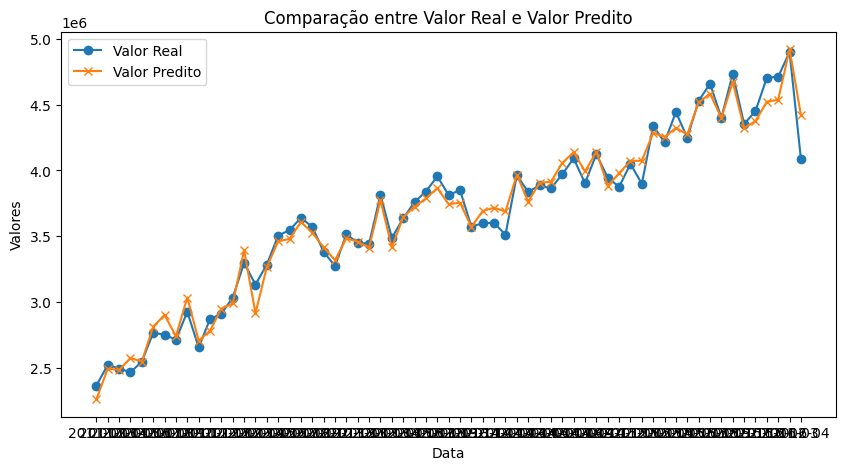

In [ ]:
    # COMPARANDO OS DADOS REAIS E OS PREDITOS EM GRÁFICO

    import plotly.express as px
    fig = px.line(forecast, x='ds', y='yhat', title='Previsão com Prophet')




    df_real = pd.DataFrame(dados_frame_agrupamento)
    df_merged = pd.merge(df_real, forecast[['ds', 'yhat']], on='ds', how='left')
    df_merged

    # Plotando os dados
    plt.figure(figsize=(10, 5))
    plt.plot(df_merged['ds'], df_merged['y'], label='Valor Real', marker='o')
    plt.plot(df_merged['ds'], df_merged['yhat'], label='Valor Predito', marker='x')

    # Adicionando título e rótulos
    plt.title('Comparação entre Valor Real e Valor Predito')
    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.legend()

In [ ]:
# ANALISANDO OS CLUSTERS

final = dados_frame_completo_carregar_labels.groupby(['Grupo'])[['SOMA']].mean().reset_index()

In [ ]:
# FAREI O AGRUPAMENTO DE CADA CLUSTER PARA TERMOS MAIS INSIGHTS

final['SOMA_TOTAL'] = final['SOMA'].sum()
final['PERCENTUAL_SOMA'] = final['SOMA'] / final['SOMA_TOTAL']
final['SOMA'] = final['SOMA'].apply(lambda x: f'${x:,.2f}')
final['SOMA_TOTAL'] = final['SOMA_TOTAL'].apply(lambda x: f'R${x:,.2f}')
final['PERCENTUAL_SOMA'] = final['PERCENTUAL_SOMA'].apply(lambda x: f'{x * 100:.2f}%')
print(final)

   Grupo     SOMA  SOMA_TOTAL PERCENTUAL_SOMA
0      0  $119.47  R$1,299.41           9.19%
1      1  $140.69  R$1,299.41          10.83%
2      2  $127.68  R$1,299.41           9.83%
3      3  $285.51  R$1,299.41          21.97%
4      4  $626.06  R$1,299.41          48.18%


In [ ]:
final2 = dados_frame_completo_carregar_labels.groupby(['Grupo'])[['sales']].mean().reset_index()

In [ ]:
final2['sales_TOTAL'] = final2['sales'].sum()
final2['PERCENTUAL_SALES'] = final2['sales'] / final2['sales_TOTAL']
final2['sales'] = final2['sales'].apply(lambda x: f'{int(x):,}'.replace(',', '.'))
final2['sales_TOTAL'] = final2['sales_TOTAL'].apply(lambda x: f'{int(x):,}'.replace(',', '.'))
final2['PERCENTUAL_SALES'] = final2['PERCENTUAL_SALES'].apply(lambda x: f'{x * 100:.2f}%')
print(final2)

   Grupo sales sales_TOTAL PERCENTUAL_SALES
0      0    29         424            6.93%
1      1    30         424            7.09%
2      2    31         424            7.31%
3      3    14         424            3.48%
4      4   319         424           75.19%


In [ ]:
final3 = dados_frame_completo_carregar_labels.groupby(['Grupo'])[['mean_price']].mean().reset_index()

In [ ]:
final3['mean_price_TOTAL'] = final3['mean_price'].sum()
final3['PERCENTUAL_MEAN'] = final3['mean_price'] / final3['mean_price_TOTAL']

final3['mean_price'] = final3['mean_price'].apply(lambda x: f'${x:,.2f}')
final3['mean_price_TOTAL'] = final3['mean_price_TOTAL'].apply(lambda x: f'R${x:,.2f}')
final3['PERCENTUAL_MEAN'] = final3['PERCENTUAL_MEAN'].apply(lambda x: f'{x * 100:.2f}%')
final3

,Grupo,mean_price,mean_price_TOTAL,PERCENTUAL_MEAN
0,0,$4.95,R$35.73,13.84%
1,1,$5.04,R$35.73,14.10%
2,2,$4.96,R$35.73,13.87%
3,3,$18.94,R$35.73,53.00%
4,4,$1.86,R$35.73,5.19%


In [ ]:
# JUNTANDO TODOS OS DADOS, POR CLUSTER, PODEMOS VER QUE HÁ UM CLUSTER QUE APRESENTA UMA SOMA MUITO MAIOR QUE OS OUTROS. NO CASO O CLUSTER 4

# ESTE CLUSTER TEM A CARACTERÍSTICA DE TER PRODUTOS BARATOS, MAS COM UMA QUANTIDADE MUITO GRANDE DE VENDAS

# OUTRO CLUSTER INTERESSANTE É O SEGUNDO CLUSTER COM MAIS VENDAS (3), QUE MOSTRA PRODUTO DE ALTO VALOR MÉDIO, MAS COM POUCAS VENDAS POR UNIDADE



merged_df = pd.merge(final, final2, on='Grupo', how='outer')


merged_df = pd.merge(merged_df, final3, on='Grupo', how='outer')

merged_df


,Grupo,SOMA,SOMA_TOTAL,PERCENTUAL_SOMA,sales,sales_TOTAL,PERCENTUAL_SALES,mean_price,mean_price_TOTAL,PERCENTUAL_MEAN
0,0,$119.47,"R$1,299.41",9.19%,29,424,6.93%,$4.95,R$35.73,13.84%
1,1,$140.69,"R$1,299.41",10.83%,30,424,7.09%,$5.04,R$35.73,14.10%
2,2,$127.68,"R$1,299.41",9.83%,31,424,7.31%,$4.96,R$35.73,13.87%
3,3,$285.51,"R$1,299.41",21.97%,14,424,3.48%,$18.94,R$35.73,53.00%
4,4,$626.06,"R$1,299.41",48.18%,319,424,75.19%,$1.86,R$35.73,5.19%


In [ ]:
a = merged_df.reset_index(drop=True)
a

,Grupo,SOMA,SOMA_TOTAL,PERCENTUAL_SOMA,sales,sales_TOTAL,PERCENTUAL_SALES,mean_price,mean_price_TOTAL,PERCENTUAL_MEAN
0,0,$119.47,"R$1,299.41",9.19%,29,424,6.93%,$4.95,R$35.73,13.84%
1,1,$140.69,"R$1,299.41",10.83%,30,424,7.09%,$5.04,R$35.73,14.10%
2,2,$127.68,"R$1,299.41",9.83%,31,424,7.31%,$4.96,R$35.73,13.87%
3,3,$285.51,"R$1,299.41",21.97%,14,424,3.48%,$18.94,R$35.73,53.00%
4,4,$626.06,"R$1,299.41",48.18%,319,424,75.19%,$1.86,R$35.73,5.19%
